---
# **Assignment 2 for Clustering: Sessa Empirical Estimator**  
---

# Introduction

In this analysis, our primary goal is to estimate the duration between consecutive prescription fills—an essential step in understanding medication adherence patterns. We achieve this through the Sessa Empirical Estimator, which computes and refines temporal intervals before applying clustering techniques to derive robust duration estimates.

## Objectives

1. **Compute Temporal Intervals:**  
   Calculate the gaps between consecutive prescription fills for each patient.

2. **Filter Out Extreme Gaps:**  
   Use the empirical cumulative distribution (ECDF) of these intervals to retain only the lower 80% of gaps, effectively filtering out extremely long intervals that may represent outliers.

3. **Standardize Intervals:**  
   Standardize the filtered temporal intervals to ensure comparability and improve the clustering performance.

4. **Clustering Approaches:**  
   Apply two different clustering methods to the standardized intervals:
   - **K-Means Clustering:**  
     The original approach used in the SEE method, which forces every data point into a predefined number of clusters.
   - **DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**  
     An alternative approach that detects clusters based on data density and can naturally identify noise (outliers) without forcing every point into a cluster.

5. **Duration Estimation:**  
   For each cluster produced by the clustering algorithm, compute the median of the event intervals. This median serves as the estimated duration for that cluster.

6. **Comparison of Clustering Methods:**  
   Compare the results and insights obtained from the two clustering methods, highlighting the advantages and limitations of each approach in the context of estimating prescription fill durations.

By systematically following these steps, we aim to develop a robust framework for analyzing medication adherence through the lens of prescription refill patterns.


$\textbf{R code - Python Code}$

- $\textbf{Using the Med.Events dataset}$

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


# Step 1: Load & Preprocess Data
file_path = "med_events.csv"
df = pd.read_csv(file_path)

df.rename(columns={
    "PATIENT_ID": "pnr",    # Patient ID
    "DATE": "eksd",         # Prescription date
    "PERDAY": "perday",     # Daily dosage
    "CATEGORY": "ATC",      # Drug type
    "DURATION": "dur_original"  # Prescription duration
}, inplace=True)

df["eksd"] = pd.to_datetime(df["eksd"], format="%m/%d/%Y")
df = df.sort_values(by=["pnr", "eksd"])

# Step 1.5: Do NOT filter only one drug
df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
df["event.interval"] = (df["eksd"] - df["prev_eksd"]).dt.days
df = df.dropna(subset=["event.interval"])


# Step 2: Compute Event Intervals
df["prev_eksd"] = df.groupby("pnr")["eksd"].shift(1)
df["event.interval"] = (df["eksd"] - df["prev_eksd"]).dt.days
df = df.dropna(subset=["event.interval"])

# Step 2.5: Randomly Select One Prescription Per Patient (For Both Drugs)
df_filtered = df.groupby(["pnr", "ATC"]).apply(lambda x: x.sample(n=min(1, len(x)), random_state=42)).reset_index(drop=True)

df_filtered.head()

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval
0,1,2033-08-03,4,medB,30,2033-07-04,30.0
1,2,2036-08-01,4,medA,50,2036-03-10,144.0
2,2,2036-09-21,4,medB,60,2036-08-01,51.0
3,3,2043-01-23,4,medB,30,2042-12-17,37.0
4,4,2033-08-20,4,medA,50,2032-11-27,266.0


$\textbf{ II. Generating the Emperical CDF and filtering the top 20 percent}$ 

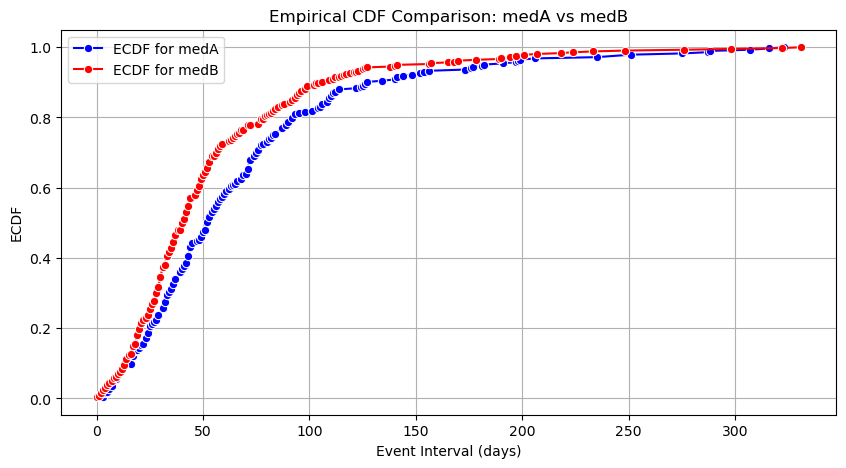

,pnr,eksd,perday,ATC,dur_original,prev_eksd,event.interval,Cluster
0,1,2033-08-03,4,medB,30,2033-07-04,30.0,0
2,2,2036-09-21,4,medB,60,2036-08-01,51.0,1
3,3,2043-01-23,4,medB,30,2042-12-17,37.0,0
6,5,2032-03-04,8,medA,30,2032-01-25,39.0,0
7,5,2033-02-17,4,medB,60,2032-12-23,56.0,1


In [2]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 3: Generate ECDF for both medA and medB
plt.figure(figsize=(10, 5))

for drug, color in zip(["medA", "medB"], ["blue", "red"]):
    df_drug = df[df["ATC"] == drug].copy()
    
    if df_drug.empty:
        print(f"⚠️ Warning: No data found for {drug}. Skipping ECDF plot.")
        continue  # Skip this drug if no data

    df_drug["prev_eksd"] = df_drug.groupby("pnr")["eksd"].shift(1)
    df_drug["event.interval"] = (df_drug["eksd"] - df_drug["prev_eksd"]).dt.days
    df_drug = df_drug.dropna(subset=["event.interval"])

    event_intervals = df_drug["event.interval"]
    
    if event_intervals.empty:
        print(f"⚠️ Warning: No valid event intervals for {drug}. Skipping ECDF plot.")
        continue  # Skip ECDF calculation if no event intervals

    ecdf = ECDF(event_intervals)
    x = np.sort(event_intervals)
    y = ecdf(x)

    sns.lineplot(x=x, y=y, marker="o", label=f"ECDF for {drug}", color=color)

# Formatting the plot
plt.xlabel("Event Interval (days)")
plt.ylabel("ECDF")
plt.title("Empirical CDF Comparison: medA vs medB")
plt.legend()
plt.grid()
plt.show()

# Step 4: Remove Top 20%
threshold = np.percentile(event_intervals, 80)  # 80th percentile cutoff
df_filtered = df_filtered[df_filtered["event.interval"] <= threshold].copy()

# **Fix: Set n_init="auto" to avoid the warning**
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_filtered[["event.interval"]])  # Scale the data

# Fix warning: explicitly set n_init
kmeans_final = KMeans(n_clusters=3, n_init="auto", random_state=42)
df_filtered["Cluster"] = kmeans_final.fit_predict(scaled_data)  # Train & predict

df_filtered.head()


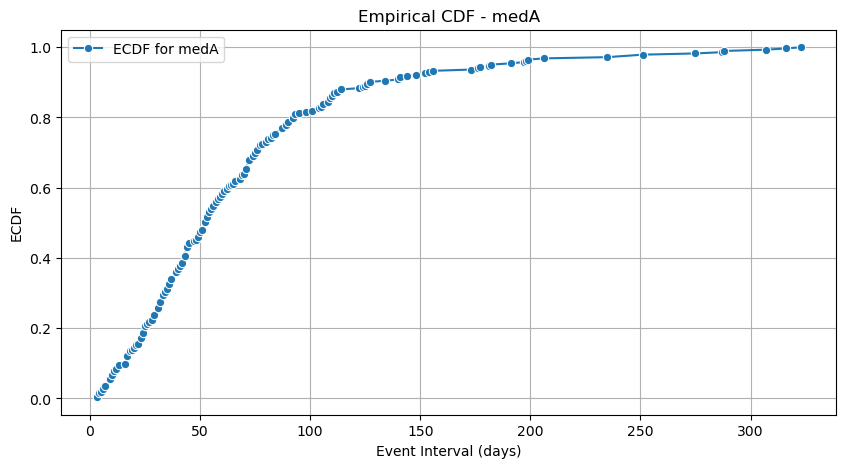

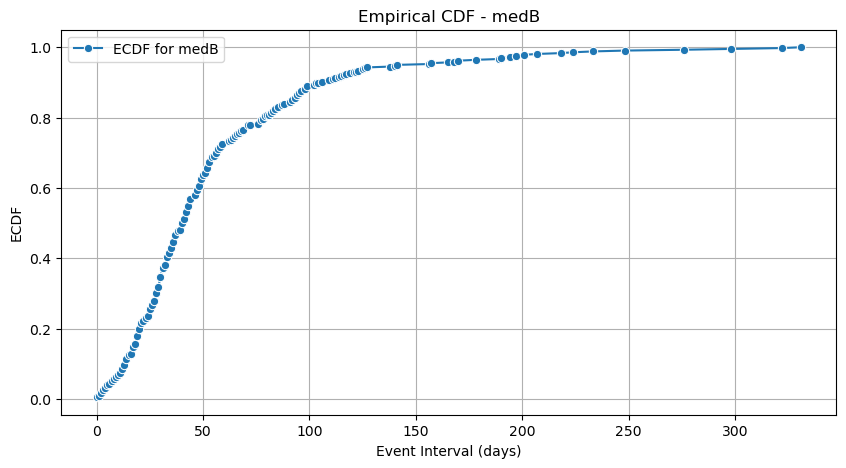

In [3]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np

for drug in ["medA", "medB"]:
    df_drug = df[df["ATC"] == drug].copy()

    if df_drug.empty:
        print(f"⚠️ Warning: No data found for {drug}. Skipping ECDF plot.")
        continue

    # Compute event intervals
    df_drug["prev_eksd"] = df_drug.groupby("pnr")["eksd"].shift(1)
    df_drug["event.interval"] = (df_drug["eksd"] - df_drug["prev_eksd"]).dt.days
    df_drug = df_drug.dropna(subset=["event.interval"])

    event_intervals = df_drug["event.interval"]
    
    if event_intervals.empty:
        print(f"⚠️ Warning: No valid event intervals for {drug}. Skipping ECDF plot.")
        continue

    # ECDF Plot
    ecdf = ECDF(event_intervals)
    x = np.sort(event_intervals)
    y = ecdf(x)

    plt.figure(figsize=(10, 5))
    sns.lineplot(x=x, y=y, marker="o", label=f"ECDF for {drug}")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("ECDF")
    plt.title(f"Empirical CDF - {drug}")
    plt.grid()
    plt.legend()
    plt.show()

    # Remove Top 20%
    threshold = np.percentile(event_intervals, 80)
    df_drug = df_drug[df_drug["event.interval"] <= threshold].copy()

    # Store processed data for clustering in next cell
    if drug == "medA":
        df_medA_filtered = df_drug.copy()
    else:
        df_medB_filtered = df_drug.copy()


$\textbf{ III. Applying K-means clustering}$ 

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

for drug, df_drug in zip(["medA", "medB"], [df_medA_filtered, df_medB_filtered]):
    if df_drug.empty:
        print(f"⚠️ Warning: No filtered data for {drug}. Skipping clustering.")
        continue

    # Extract event intervals for clustering
    X = df_drug[["event.interval"]]

    # Scale Data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Find Optimal Number of Clusters using Silhouette Score
    sil_scores = []
    cluster_range = range(2, 10)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, algorithm="elkan", random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        sil_scores.append(score)

    optimal_k = cluster_range[np.argmax(sil_scores)]
    kmeans_final = KMeans(n_clusters=optimal_k, algorithm="elkan", random_state=42, n_init=10)
    df_drug["Cluster"] = kmeans_final.fit_predict(X_scaled)

    print(f"🔹 Clustering Results for {drug}:")
    print(df_drug.head())


🔹 Clustering Results for medA:
    pnr       eksd  perday   ATC  dur_original  prev_eksd  event.interval  \
63    4 2033-08-30       4  medA            50 2033-08-20            10.0   
69    5 2032-03-04       8  medA            30 2032-01-25            39.0   
72    5 2032-12-23       8  medA            30 2032-12-17             6.0   
87    7 2043-06-03       2  medA           100 2043-03-18            77.0   
88    7 2043-08-01       2  medA           100 2043-06-03            59.0   

    Cluster  
63        2  
69        7  
72        2  
87        6  
88        1  
🔹 Clustering Results for medB:
   pnr       eksd  perday   ATC  dur_original  prev_eksd  event.interval  \
3    1 2033-08-17       4  medB            30 2033-08-03            14.0   
4    1 2033-10-13       4  medB            30 2033-08-17            57.0   
5    1 2033-10-16       4  medB            30 2033-10-13             3.0   
6    1 2033-11-23       4  medB            30 2033-10-16            38.0   
7    1 2034

$\textbf{ IV. Assigning Cluster Statistics}$ 

In [5]:
# Create an empty list to store results for both drugs
all_results = []

for drug, df_drug in zip(["medA", "medB"], [df_medA_filtered, df_medB_filtered]):
    if df_drug.empty:
        print(f"⚠️ Warning: No filtered data for {drug}. Skipping cluster analysis.")
        continue

    print(f"🔹 Processing Cluster Statistics for {drug}...")

    # Step 5: Compute Cluster Statistics
    ni2 = df_drug.groupby("Cluster")["event.interval"].min()
    ni3 = df_drug.groupby("Cluster")["event.interval"].max()
    ni4 = df_drug.groupby("Cluster")["event.interval"].median()

    cluster_stats = pd.DataFrame({
        "Cluster": ni2.index,
        "Minimum": ni2.values,
        "Maximum": ni3.values,
        "Median": ni4.values
    })
    cluster_stats = cluster_stats[cluster_stats["Median"] > 0]  # Remove invalid clusters

    # Step 6: Assign Patients to Clusters
    results = df.merge(df_drug[["pnr", "Cluster"]], on="pnr", how="left")

    # Merge with cluster statistics
    results = results.merge(cluster_stats, on="Cluster", how="left")

    # Keep only patients within their cluster's interval range
    results = results[(results["event.interval"] >= results["Minimum"]) & 
                      (results["event.interval"] <= results["Maximum"])]

    # Drop unassigned patients
    results.dropna(subset=["Cluster"], inplace=True)

    print(f"🔹 Final Cluster Assignments for {drug}:")
    print(results.head())

    # Add a column for drug type
    results["Drug"] = drug

    # Store results
    all_results.append(results)

# Combine medA and medB results for final comparison
final_results = pd.concat(all_results, ignore_index=True)

print("🔹 Combined Cluster Results for medA & medB:")
print(final_results.head())


🔹 Processing Cluster Statistics for medA...
🔹 Final Cluster Assignments for medA:
    pnr       eksd  perday   ATC  dur_original  prev_eksd  event.interval  \
55    4 2033-08-30       4  medA            50 2033-08-20            10.0   
60    5 2032-03-04       8  medA            30 2032-01-25            39.0   
67    5 2032-12-23       8  medA            30 2032-12-17             6.0   
82    7 2043-06-03       2  medA           100 2043-03-29            66.0   
84    7 2043-08-01       2  medA           100 2043-06-03            59.0   

    Cluster  Minimum  Maximum  Median  
55      2.0      3.0     13.0     9.0  
60      7.0     39.0     47.0    43.0  
67      2.0      3.0     13.0     9.0  
82      1.0     57.0     66.0    60.5  
84      1.0     57.0     66.0    60.5  
🔹 Processing Cluster Statistics for medB...
🔹 Final Cluster Assignments for medB:
    pnr       eksd  perday   ATC  dur_original  prev_eksd  event.interval  \
6     1 2033-08-03       4  medB            30 2033-07-0

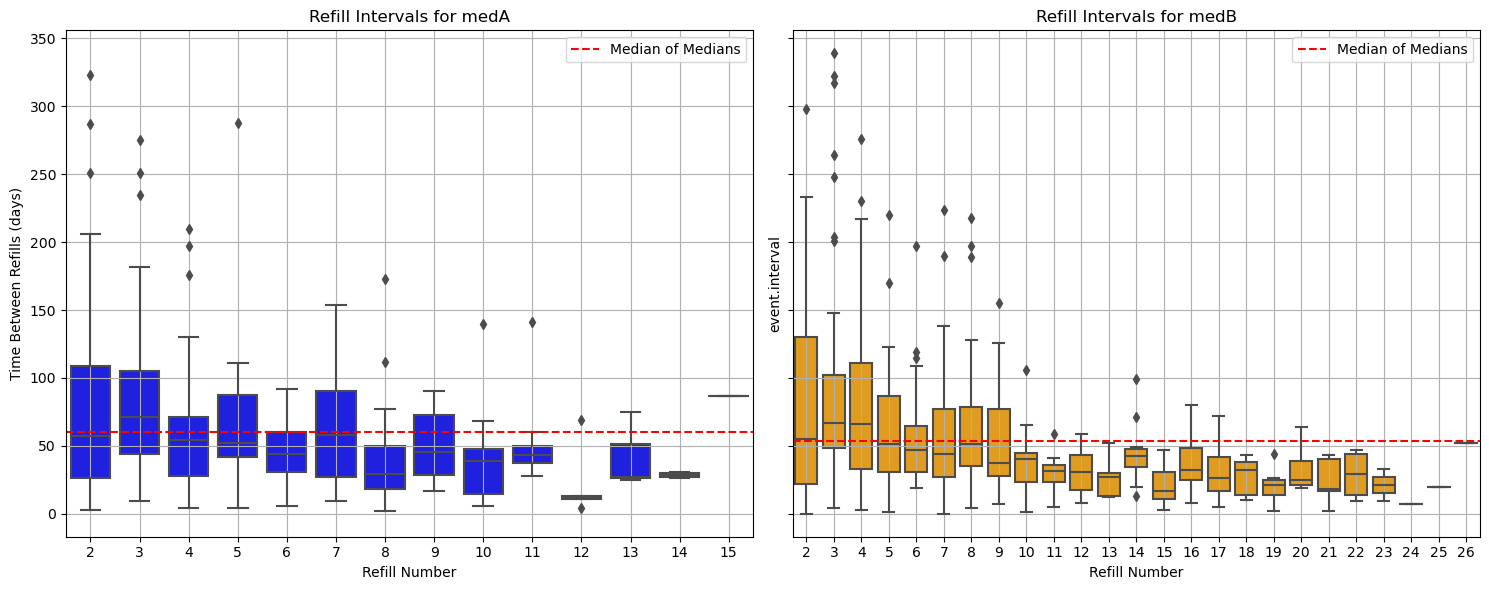

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 7: SEE Assumption Check (Separate Whisker Plots for medA & medB)

# Compute refill sequence number (p_number) per patient
df["p_number"] = df.groupby("pnr").cumcount() + 1

# Filter to remove first refill, as done in R script (only p_number >= 2)
df_filtered = df[df["p_number"] >= 2].copy()

# Separate medA and medB
df_medA = df_filtered[df_filtered["ATC"] == "medA"].copy()
df_medB = df_filtered[df_filtered["ATC"] == "medB"].copy()

# Compute median of medians per patient separately for medA & medB
medians_of_medians_A = df_medA.groupby("pnr")["event.interval"].median().median()
medians_of_medians_B = df_medB.groupby("pnr")["event.interval"].median().median()

fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)  # Two side-by-side plots

# Boxplot for medA
sns.boxplot(x="p_number", y="event.interval", data=df_medA, ax=axes[0], color="blue")
axes[0].axhline(y=medians_of_medians_A, linestyle="dashed", color="red", label="Median of Medians")
axes[0].set_title("Refill Intervals for medA")
axes[0].set_xlabel("Refill Number")
axes[0].set_ylabel("Time Between Refills (days)")
axes[0].legend()
axes[0].grid()

# Boxplot for medB
sns.boxplot(x="p_number", y="event.interval", data=df_medB, ax=axes[1], color="orange")
axes[1].axhline(y=medians_of_medians_B, linestyle="dashed", color="red", label="Median of Medians")
axes[1].set_title("Refill Intervals for medB")
axes[1].set_xlabel("Refill Number")
axes[1].legend()
axes[1].grid()

plt.tight_layout()  # Adjust layout to fit both plots nicely
plt.show()


$\textbf{ K-means Cluster Statistics}$ 

Optimal k: 9, Silhouette Score: 0.61


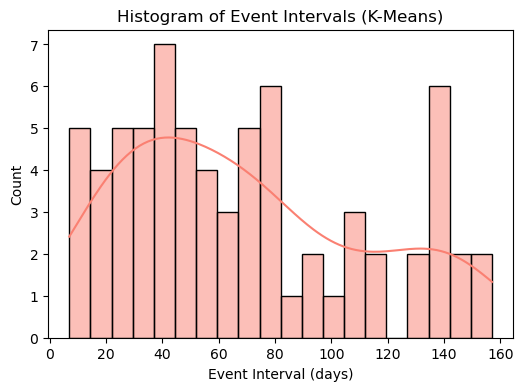

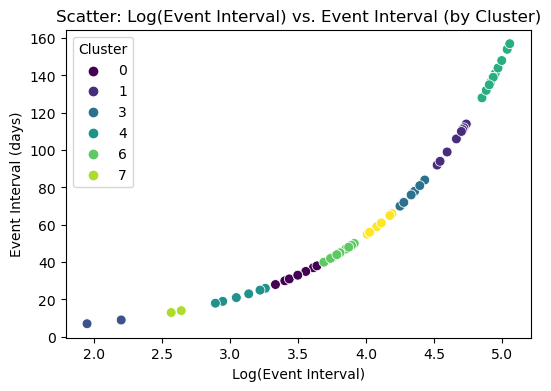

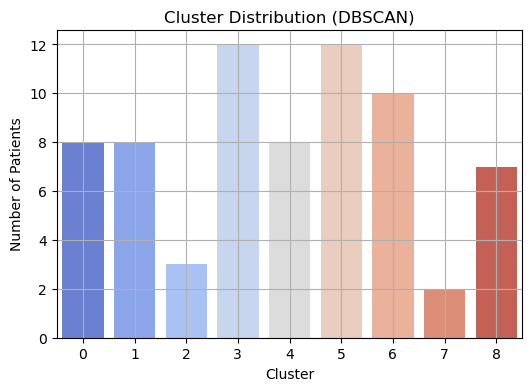

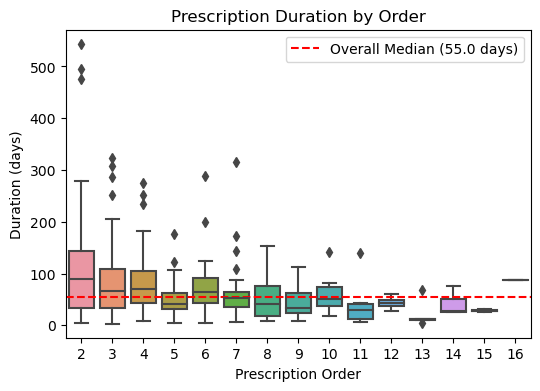

   pnr       eksd  perday   ATC  dur_original  prev_eksd  median_interval  \
0    2 2036-03-10       4  medA            50 2036-01-20        44.497191   
1    2 2036-08-01       4  medA            50 2036-03-10        44.497191   
2    4 2032-11-27       4  medA            50 2032-05-01        76.000000   
3    4 2033-08-20       4  medA            50 2032-11-27        76.000000   
4    4 2033-08-30       4  medA            50 2033-08-20        76.000000   

   cluster  
0        6  
1        6  
2        0  
3        0  
4        0  


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import random

# 1. Load Data
def load_data(file_path, expected_cols):
    df = pd.read_csv(file_path)
    if not all(col in df.columns for col in expected_cols):
        if len(df.columns) == len(expected_cols):
            df.columns = expected_cols
        else:
            raise KeyError(f"CSV does not have expected columns: {expected_cols}")
    # Convert 'eksd' to datetime (assuming mm/dd/yyyy format)
    df['eksd'] = pd.to_datetime(df['eksd'], format='%m/%d/%Y', errors='coerce')
    return df

# 2. Filter Data by Drug Code
def filter_data_by_drug(df, drug_code):
    data = df[df['ATC'] == drug_code].copy()
    data.sort_values(['pnr', 'eksd'], inplace=True)
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data = data.dropna(subset=['prev_eksd']).copy()
    return data

# 3. Sample One Consecutive Pair per Patient
def sample_data(data, random_state=1234):
    sampled = data.groupby('pnr', group_keys=False).sample(n=1, random_state=random_state).reset_index(drop=True)
    sampled['event_interval'] = (sampled['eksd'] - sampled['prev_eksd']).dt.days.astype(float)
    return sampled

# 4. Filter Event Intervals Using ECDF (retain lower 80%)
def filter_event_intervals(sampled):
    intervals = np.sort(sampled['event_interval'].values)
    n = len(intervals)
    ecdf_y = np.arange(1, n + 1) / n
    df_ecdf = pd.DataFrame({'x': intervals, 'y': ecdf_y})
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    threshold = df_ecdf_80['x'].max() if not df_ecdf_80.empty else np.percentile(sampled['event_interval'], 80)
    valid = sampled[sampled['event_interval'] <= threshold].copy()
    valid = valid[valid['event_interval'] > 0].copy()  # Only positive intervals
    return valid

# 5. Log-Transform the Event Intervals
def log_transform(valid):
    valid['log_interval'] = np.log(valid['event_interval'])
    return valid

# 6. Apply K-Means Clustering (determine optimal k via silhouette score)
def apply_kmeans(valid, random_state=1234):
    X = valid['log_interval'].values.reshape(-1, 1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    best_k = 2
    best_score = -1
    for k in range(2, min(10, len(X_scaled))):
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        labels = km.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        if score > best_score:
            best_score = score
            best_k = k
    km_final = KMeans(n_clusters=best_k, random_state=random_state, n_init=10)
    valid['cluster'] = km_final.fit_predict(X_scaled)
    return valid, best_k, best_score

# 7. Compute Cluster Medians (back-transform from log scale)
def compute_cluster_medians(valid):
    cluster_medians = valid.groupby('cluster')['log_interval'].median().apply(np.exp).reset_index()
    cluster_medians.columns = ['cluster', 'median_interval']
    return cluster_medians

# 8. Merge Clustering Info Back into Sampled Data
def merge_results(sampled, valid, cluster_medians):
    sampled = pd.merge(sampled, valid[['pnr', 'cluster']], on='pnr', how='left')
    sampled = pd.merge(sampled, cluster_medians, on='cluster', how='left')
    overall_median = sampled['event_interval'].median()
    sampled['median_interval'] = sampled['median_interval'].fillna(overall_median)
    sampled['cluster'] = sampled['cluster'].fillna(0).astype(int)
    return sampled

# 9. Merge Results with Full Data
def merge_with_full_data(data, sampled):
    final_data = pd.merge(data, sampled[['pnr', 'median_interval', 'cluster']], on='pnr', how='left')
    overall_median = sampled['event_interval'].median()
    final_data['median_interval'] = final_data['median_interval'].fillna(overall_median)
    final_data['cluster'] = final_data['cluster'].fillna(0).astype(int)
    return final_data

# 10. Plotting Functions
def plot_histogram(valid):
    plt.figure(figsize=(6, 4))
    sns.histplot(valid['event_interval'], bins=20, kde=True, color='salmon')
    plt.title("Histogram of Event Intervals (K-Means)")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("Count")
    plt.show()

def plot_scatter(valid):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=valid['log_interval'], y=valid['event_interval'], 
                    hue=valid['cluster'], palette="viridis", s=50)
    plt.title("Scatter: Log(Event Interval) vs. Event Interval (by Cluster)")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Event Interval (days)")
    plt.legend(title="Cluster")
    plt.show()

def plot_cluster_distribution(valid):
    plt.figure(figsize=(6, 4))

    # Fix: Remove `hue='cluster'` and `legend=False`
    sns.countplot(x='cluster', data=valid, palette="coolwarm")

    plt.title("Cluster Distribution (DBSCAN)")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Patients")
    plt.grid()
    plt.show()

def plot_boxplot_prescription_order(data):
    data_sorted = data.sort_values(['pnr', 'eksd']).copy()
    data_sorted['p_number'] = data_sorted.groupby('pnr').cumcount() + 1
    data_sorted['prev_eksd'] = data_sorted.groupby('pnr')['eksd'].shift(1)
    data_sorted = data_sorted.dropna(subset=['prev_eksd'])
    data_sorted['Duration'] = (data_sorted['eksd'] - data_sorted['prev_eksd']).dt.days
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='p_number', y='Duration', data=data_sorted)
    overall_median = data_sorted['Duration'].median()
    plt.axhline(overall_median, color='red', linestyle='--', label=f"Overall Median ({overall_median:.1f} days)")
    plt.title("Prescription Duration by Order")
    plt.xlabel("Prescription Order")
    plt.ylabel("Duration (days)")
    plt.legend()
    plt.show()

# 11. Run the Pipeline
if __name__ == "__main__":
    expected_cols = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    file_path = "med_events.csv"
    
    # Step 1: Load Data
    df = load_data(file_path, expected_cols)
    
    # Step 2: Filter Data for a specific drug (e.g., "medA")
    drug = "medA"
    data = filter_data_by_drug(df, drug)
    
    # Step 3: Sample Data (one consecutive pair per patient)
    sampled = sample_data(data)
    
    # Step 4: Filter Event Intervals via ECDF (retain lower 80%)
    valid = filter_event_intervals(sampled)
    
    # Step 5: Log-transform the event intervals
    valid = log_transform(valid)
    
    # Step 6: Apply K-Means Clustering
    valid, best_k, best_score = apply_kmeans(valid)
    print(f"Optimal k: {best_k}, Silhouette Score: {best_score:.2f}")
    
    # Step 7: Compute Cluster Medians (back-transform)
    cluster_medians = compute_cluster_medians(valid)
    
    # Step 8: Merge clustering results back into sampled data
    sampled = merge_results(sampled, valid, cluster_medians)
    
    # Step 9: Merge with the full data
    final_data = merge_with_full_data(data, sampled)
    
    # Step 10: Plot graphs for insights
    plot_histogram(valid)
    plot_scatter(valid)
    plot_cluster_distribution(valid)
    plot_boxplot_prescription_order(final_data)
    
    # Preview final results
    print(final_data.head())


$\textbf{ DBSCAN Statistics}$ 

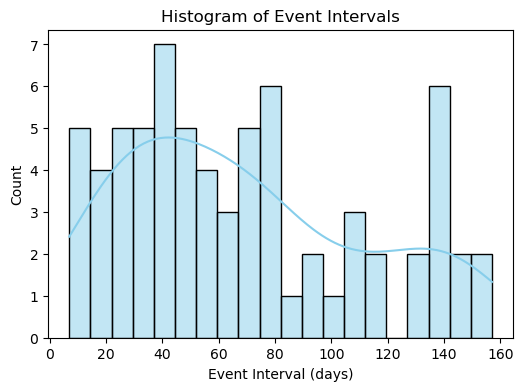

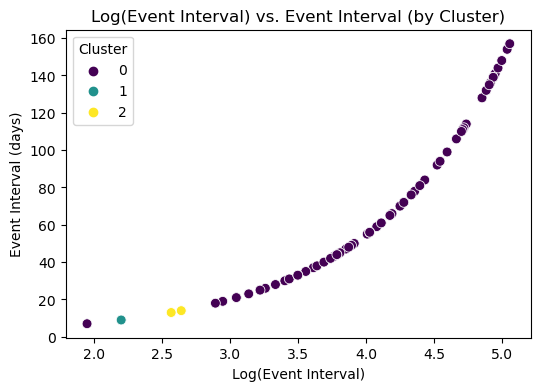

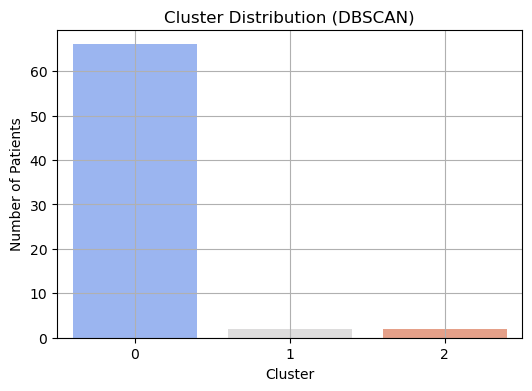

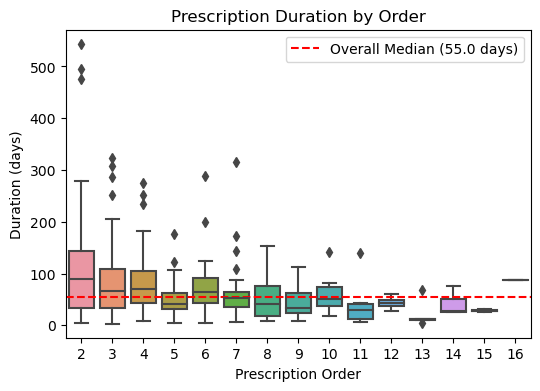

   pnr       eksd  perday   ATC  dur_original  prev_eksd  median_interval  \
0    2 2036-03-10       4  medA            50 2036-01-20        65.498092   
1    2 2036-08-01       4  medA            50 2036-03-10        65.498092   
2    4 2032-11-27       4  medA            50 2032-05-01        76.000000   
3    4 2033-08-20       4  medA            50 2032-11-27        76.000000   
4    4 2033-08-30       4  medA            50 2033-08-20        76.000000   

   cluster  
0        0  
1        0  
2        0  
3        0  
4        0  


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import random

# 1. Data Loading
def load_data(file_path, expected_cols):
    df = pd.read_csv(file_path)
    if not all(col in df.columns for col in expected_cols):
        if len(df.columns) == len(expected_cols):
            df.columns = expected_cols
        else:
            raise KeyError(f"CSV does not have expected columns: {expected_cols}")
    # Convert date column; adjust format if necessary.
    df['eksd'] = pd.to_datetime(df['eksd'], format='%m/%d/%Y', errors='coerce')
    return df

# 2. Data Filtering (by drug code)
def filter_data_by_drug(df, drug_code):
    data = df[df['ATC'] == drug_code].copy()
    data.sort_values(['pnr', 'eksd'], inplace=True)
    data['prev_eksd'] = data.groupby('pnr')['eksd'].shift(1)
    data = data.dropna(subset=['prev_eksd']).copy()
    return data

# 3. Sampling One Consecutive Pair per Patient
def sample_data(data, random_state=1234):
    sampled = data.groupby('pnr', group_keys=False).sample(n=1, random_state=random_state).reset_index(drop=True)
    sampled['event_interval'] = (sampled['eksd'] - sampled['prev_eksd']).dt.days.astype(float)
    return sampled

# 4. Filtering Event Intervals via ECDF
def filter_event_intervals(sampled):
    intervals = np.sort(sampled['event_interval'].values)
    n = len(intervals)
    ecdf_y = np.arange(1, n + 1) / n
    df_ecdf = pd.DataFrame({'x': intervals, 'y': ecdf_y})
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    threshold = df_ecdf_80['x'].max() if not df_ecdf_80.empty else np.percentile(sampled['event_interval'], 80)
    valid = sampled[sampled['event_interval'] <= threshold].copy()
    valid = valid[valid['event_interval'] > 0].copy()  # Only positive intervals
    return valid

# 5. Log-transforming the Event Intervals
def log_transform(valid):
    valid['log_interval'] = np.log(valid['event_interval'])
    return valid

# 6. Applying DBSCAN
def apply_dbscan(valid, eps=0.3, min_samples=2):
    X = valid['log_interval'].values.reshape(-1, 1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_scaled)
    valid['cluster'] = labels
    # Reassign noise (label -1) to cluster 0
    valid.loc[valid['cluster'] == -1, 'cluster'] = 0
    return valid

# 7. Computing Cluster Medians (Back-transform from log scale)
def compute_cluster_medians(valid):
    cluster_medians = valid.groupby('cluster')['log_interval'].median().apply(np.exp).reset_index()
    cluster_medians.columns = ['cluster', 'median_interval']
    return cluster_medians

# 8. Merging Cluster Info Back into Sampled Data
def merge_results(sampled, cluster_medians):
    # Merge on 'pnr' via the DBSCAN clustering assignment
    sampled = pd.merge(sampled, valid[['pnr', 'cluster']], on='pnr', how='left')
    sampled = pd.merge(sampled, cluster_medians, on='cluster', how='left')
    overall_median = sampled['event_interval'].median()
    sampled['median_interval'] = sampled['median_interval'].fillna(overall_median)
    sampled['cluster'] = sampled['cluster'].fillna(0).astype(int)
    return sampled

# 9. Merging with Full Data
def merge_with_full_data(data, sampled):
    final_data = pd.merge(data, sampled[['pnr', 'median_interval', 'cluster']], on='pnr', how='left')
    overall_median = sampled['event_interval'].median()
    final_data['median_interval'] = final_data['median_interval'].fillna(overall_median)
    final_data['cluster'] = final_data['cluster'].fillna(0).astype(int)
    return final_data

# 10. Plotting Functions for Graphs
def plot_histogram(valid):
    plt.figure(figsize=(6, 4))
    sns.histplot(valid['event_interval'], bins=20, kde=True, color='skyblue')
    plt.title("Histogram of Event Intervals")
    plt.xlabel("Event Interval (days)")
    plt.ylabel("Count")
    plt.show()

def plot_scatter(valid):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=valid['log_interval'], y=valid['event_interval'], 
                    hue=valid['cluster'], palette="viridis", s=50)
    plt.title("Log(Event Interval) vs. Event Interval (by Cluster)")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Event Interval (days)")
    plt.legend(title="Cluster")
    plt.show()

def plot_cluster_distribution(valid):
    plt.figure(figsize=(6, 4))

    # Fix: Remove `hue='cluster'` and `legend=False`
    sns.countplot(x='cluster', data=valid, palette="coolwarm")

    plt.title("Cluster Distribution (DBSCAN)")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Patients")
    plt.grid()
    plt.show()


def plot_boxplot_prescription_order(data):
    data_sorted = data.sort_values(['pnr', 'eksd']).copy()
    data_sorted['p_number'] = data_sorted.groupby('pnr').cumcount() + 1
    data_sorted['prev_eksd'] = data_sorted.groupby('pnr')['eksd'].shift(1)
    data_sorted = data_sorted.dropna(subset=['prev_eksd'])
    data_sorted['Duration'] = (data_sorted['eksd'] - data_sorted['prev_eksd']).dt.days
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='p_number', y='Duration', data=data_sorted)
    overall_median = data_sorted['Duration'].median()
    plt.axhline(overall_median, color='red', linestyle='--', 
                label=f'Overall Median ({overall_median:.1f} days)')
    plt.title("Prescription Duration by Order")
    plt.xlabel("Prescription Order")
    plt.ylabel("Duration (days)")
    plt.legend()
    plt.show()

# 11. Running the Pipeline and Checking Results
if __name__ == "__main__":
    # Specify expected columns and file path
    expected_cols = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    file_path = "med_events.csv"
    
    # Step 1: Load Data
    df = load_data(file_path, expected_cols)
    
    # Step 2: Filter Data for a specific drug (e.g., "medA")
    drug = "medA"
    data = filter_data_by_drug(df, drug)
    
    # Step 3: Sample Data (one pair per patient)
    sampled = sample_data(data)
    
    # Step 4: Filter Event Intervals using ECDF criteria
    valid = filter_event_intervals(sampled)
    
    # Step 5: Log-transform the event intervals
    valid = log_transform(valid)
    
    # Step 6: Apply DBSCAN
    valid = apply_dbscan(valid, eps=0.3, min_samples=2)
    
    # Step 7: Compute Cluster Medians
    cluster_medians = compute_cluster_medians(valid)
    
    # Step 8: Merge Cluster Information back into Sampled Data
    sampled = merge_results(sampled, cluster_medians)
    
    # Step 9: Merge the Results with the Full Data
    final_data = merge_with_full_data(data, sampled)
    
    # Step 10: Plot the Results for Verification and Insights
    plot_histogram(valid)
    plot_scatter(valid)
    plot_cluster_distribution(valid)
    plot_boxplot_prescription_order(final_data)
    
    # Print a preview of the final data to verify consistency.
    print(final_data.head())


# Disadvantages of K-Means Clustering

- **Requires prior specification of k:**  
  You must choose the number of clusters (k) in advance, which can be challenging without domain knowledge.

- **Sensitive to initialization:**  
  The algorithm's outcome can vary based on the initial placement of centroids, potentially leading to suboptimal solutions.

- **Assumes spherical clusters:**  
  K-Means tends to perform poorly when clusters have non-convex shapes or vastly different sizes and densities.

- **Affected by outliers:**  
  Outliers can significantly distort the centroid calculations, resulting in misleading cluster assignments.

- **Hard clustering:**  
  Each data point is assigned to a single cluster, which may not be ideal for datasets where points could belong to multiple clusters.

- **Not well-suited for categorical data:**  
  Since K-Means relies on mean calculations, it is not directly applicable to categorical features without proper encoding.


# Comparison: Sessa Empirical Estimator using K-Means vs. DBSCAN

## K-Means Clustering
- **Forces Every Point into a Cluster:**  
  K-Means assigns every data point to one of the predetermined k clusters, which can mask the presence of outliers.
  
- **Requires Pre-specification of k:**  
  The number of clusters must be chosen before running the algorithm. This may lead to forcing a partition even when natural groupings are unclear.
  
- **Assumption of Spherical Clusters:**  
  K-Means works best when clusters are convex and roughly equal in size. It might not capture complex, non-spherical structures in event intervals.
  
- **Sensitivity to Outliers:**  
  Outliers can skew the centroid positions and affect the computed cluster medians, potentially reducing the estimator’s robustness.

## DBSCAN Clustering
- **Identification of Noise:**  
  DBSCAN can label points as noise (e.g., assigning them to cluster 0) when they don’t belong to any dense region. This is useful for excluding outliers from the estimation.
  
- **No Need to Specify Number of Clusters:**  
  Clusters are determined based on data density, so DBSCAN automatically identifies the number of clusters. This can lead to more natural groupings in the data.
  
- **Ability to Detect Arbitrary Shapes:**  
  DBSCAN is more flexible in detecting clusters with arbitrary shapes, which can be an advantage if the event intervals have non-uniform distributions.
  
- **Parameter Sensitivity:**  
  The performance of DBSCAN depends on choosing appropriate values for `eps` and `min_samples`. Poor choices can either merge distinct clusters or mark too many points as noise.

## Observed Differences in the Context of the Estimator
- **Cluster Assignment:**  
  With K-Means, every patient’s event interval is assigned to a cluster and a corresponding median is computed, even if the data do not naturally split into distinct groups. In contrast, DBSCAN may leave some points unassigned (as noise) or group them into a single “noise” cluster, which can lead to a more robust median estimate by excluding outliers.

- **Robustness to Outliers:**  
  DBSCAN’s ability to label outliers can prevent extreme event intervals from skewing the overall estimation, whereas K-Means might be adversely affected by such points.

- **Interpretability:**  
  The forced partitioning in K-Means makes it simpler to interpret the clusters (since every patient belongs to one), but it may also oversimplify the true underlying structure. DBSCAN’s clustering can provide deeper insights into the natural density of event intervals, highlighting regions where the intervals are more (or less) consistent.

- **Graphical Differences:**  
  - **Histograms and Scatter Plots:**  
    When visualized, the histogram and scatter plots of log-transformed event intervals often show that DBSCAN identifies a denser core and separates noise, while K-Means creates a clear partition across all data points.
  - **Cluster Distribution:**  
    Bar plots of cluster frequency under DBSCAN might show a dominant cluster with a few minor ones or a noise cluster, whereas K-Means will always display exactly k clusters even if one or more clusters are relatively small or diffuse.

In summary, while K-Means provides a straightforward, partitioned clustering result, DBSCAN offers a more flexible approach that can better handle outliers and non-uniform cluster shapes, potentially leading to more robust estimates in the Sessa Empirical Estimator framework.
